## make semi supervised

In [110]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2
from celligner2 import plotting as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [3]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
dataset = read_h5ad("temp/cleanup_multi.h5ad.gz")

In [269]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=['cell_type'],
    predictor_keys=['tissue_type', 'age', "sex", 'disease_type'],
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32,64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8,
    apply_log=False,
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='tissue_type',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 2
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 65 

Decoder Architecture:
	First Layer in, out and cond:  16 128 2
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |████████------------| 41.3%  - val_loss: 4913.2400277945 - val_recon_loss: 4486.7537747897 - val_kl_loss: 65.8371828519 - val_class_ce_loss: 149.3380253132 - val_mmd_loss: 277.1077164870
ADJUSTED LR
 |██████████----------| 54.7%  - val_loss: 4868.7133225661 - val_recon_loss: 4465.6002478966 - val_kl_loss: 65.8166251549 - val_class_ce_loss: 137.8935394287 - val_mmd_loss: 265.1658043495
ADJUSTED LR
 |███████████---------| 57.0%  - val_loss: 4867.8353365385 - val_recon_loss: 4464.0457294171 - val_kl_loss: 65.8172536997 - val_class_ce_loss: 137.6680014684 - val_mmd_loss: 266.0653768686
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 149


In [267]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sex' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue_type_pred' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed 

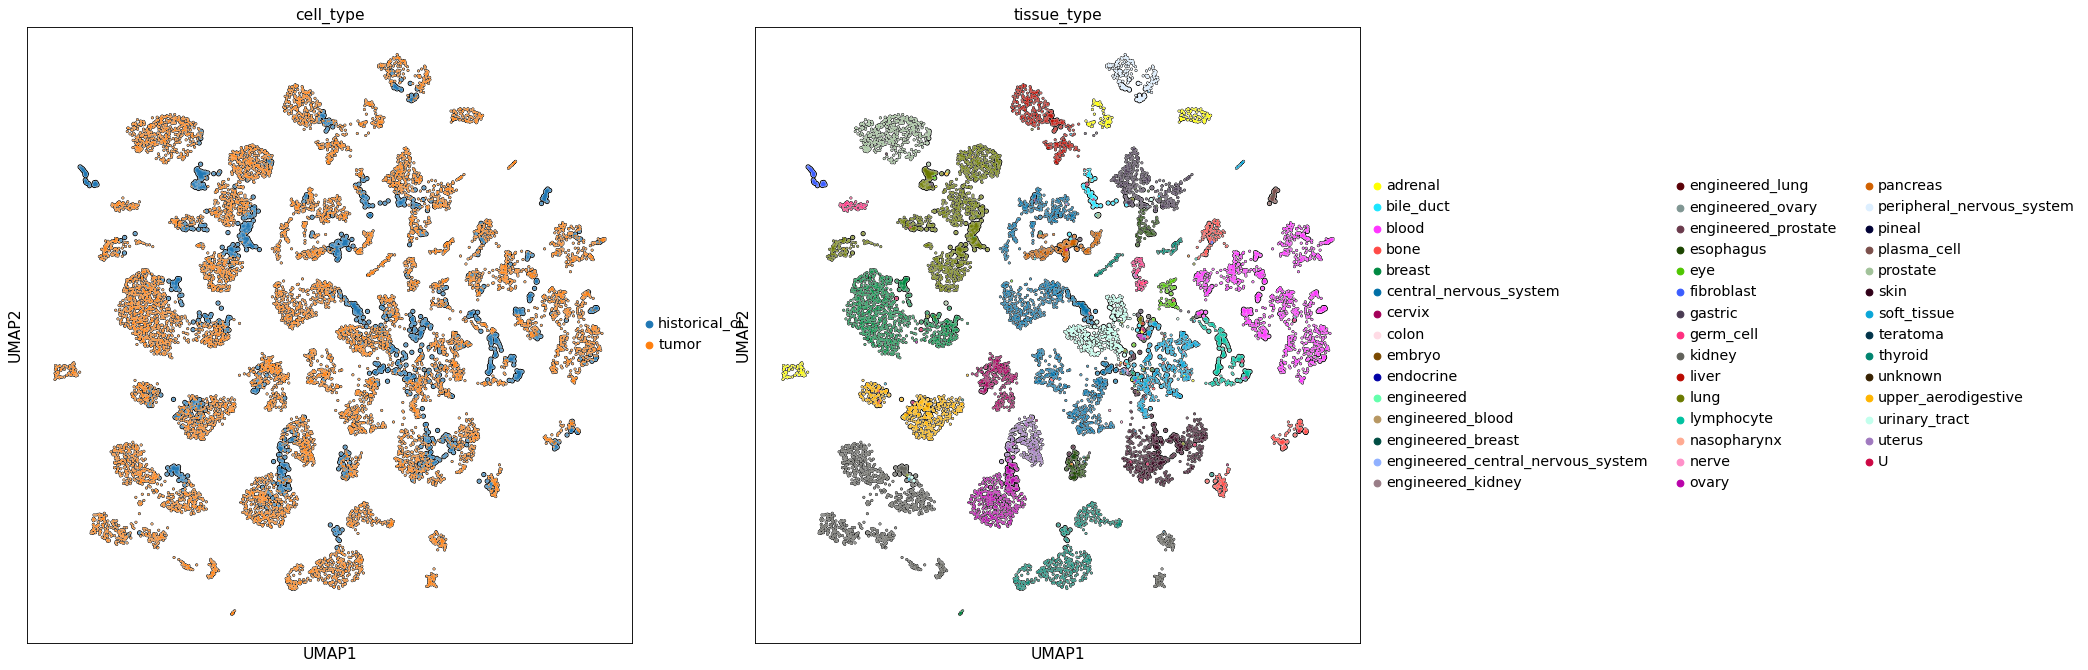

In [268]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['cell_type', 'tissue_type'],
        projection="2d",
        add_outline=True,
        size=[30]*len(dataset[dataset.obs['cell_type']=='historical_cl']) + [10]*len(dataset[dataset.obs['cell_type']=='tumor']))

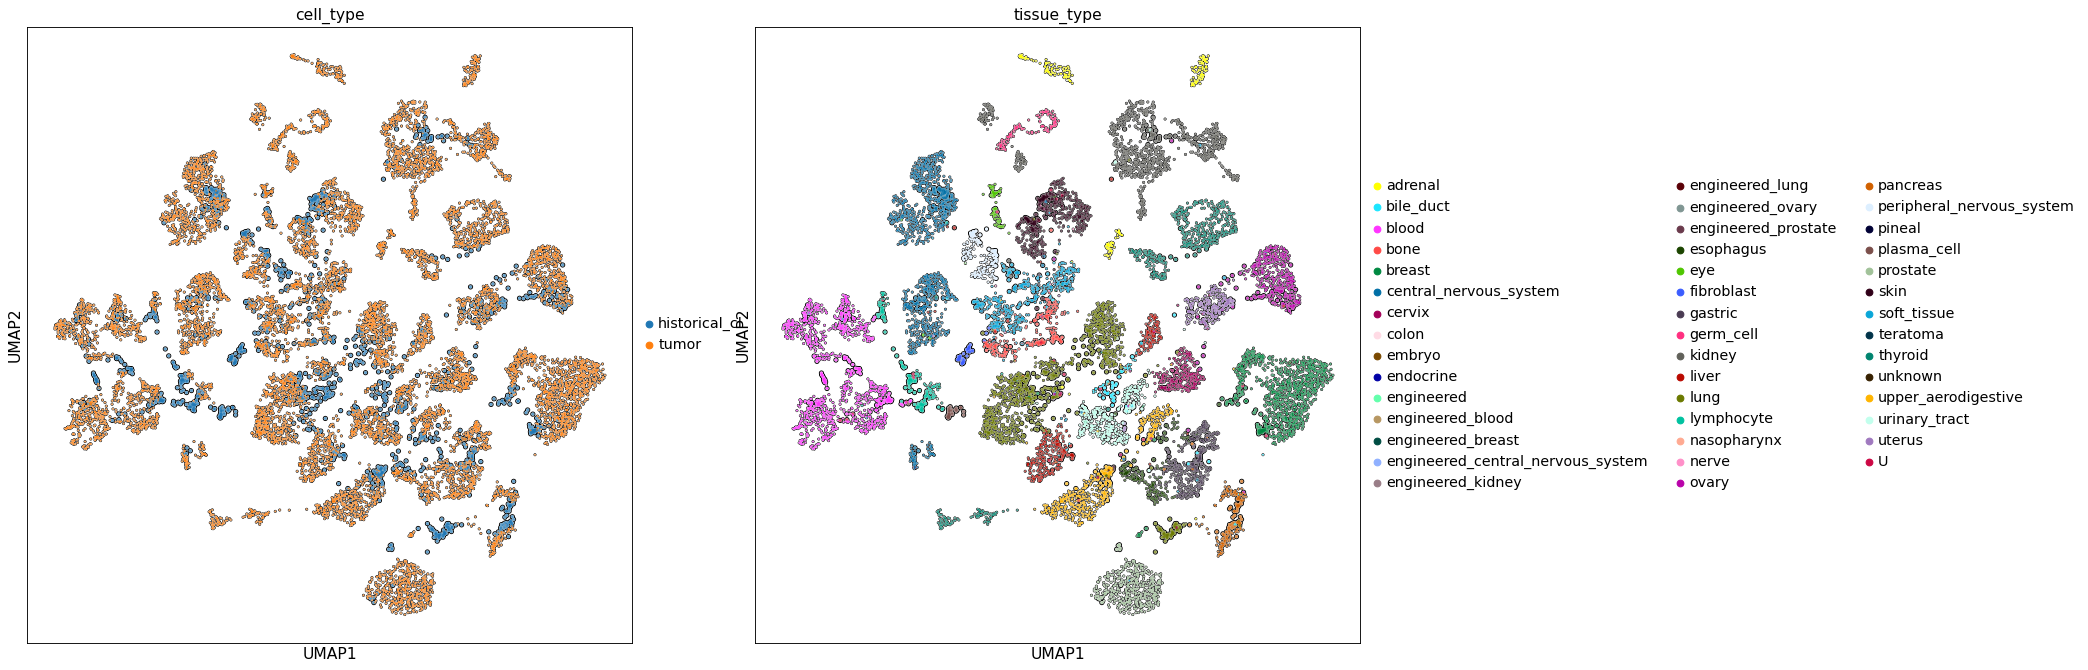

In [22]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['cell_type', 'tissue_type'],
        projection="2d",
        add_outline=True,
        size=[30]*len(dataset[dataset.obs['cell_type']=='historical_cl']) + [10]*len(dataset[dataset.obs['cell_type']=='tumor']))

In [19]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['cell_type', 'tissue_type'],
        projection="2d",
        add_outline=True,
        size=[40]*len(dataset[dataset.obs['cell_type']=='historical_cl']) + [10]*len(dataset[dataset.obs['cell_type']=='tumor']))

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will 

In [ ]:
scib

In [23]:
evaluator.get_class_quality(only="historical_cl", classes=['tissue_type', 'disease_type', 'sex', 'age'])

tissue_type
all predicted categories:  {'thyroid', 'kidney', 'cervix', 'skin', 'lymphocyte', 'peripheral_nervous_system', 'fibroblast', 'lung', 'blood', 'esophagus', 'bile_duct', 'soft_tissue', 'urinary_tract', 'pancreas', 'eye', 'uterus', 'ovary', 'plasma_cell', 'upper_aerodigestive', 'gastric', 'adrenal', 'breast', 'prostate', 'central_nervous_system', 'bone', 'liver'}
accuracy:  0.9465944272445821
F1 Score (weigthed): 0.95
F1 Score (macro): 0.94


disease_type
all predicted categories:  {'Prostate Cancer', 'Breast Cancer', 'Bladder Cancer', 'Brain Cancer', 'Cervical Cancer', 'Skin Cancer', 'Rhabdoid', 'Endometrial/Uterine Cancer', 'Pancreatic Cancer', 'Sarcoma', 'Lymphoma', 'Neuroblastoma', 'Head and Neck Cancer', 'Bile Duct Cancer', 'Adrenal Cancer', 'Ovarian Cancer', 'normal', 'Liver Cancer', 'Leukemia', 'Lung Cancer', 'Liposarcoma', 'Gastric Cancer', 'Kidney Cancer', 'Eye Cancer', 'Myeloma', 'Esophageal Cancer', 'Bone Cancer', 'Thyroid Cancer'}
accuracy:  0.943683409436834
F1 Sco

In [20]:
evaluator.get_class_quality(only="historical_cl", classes=['tissue_type', 'disease_type', 'sex', 'age'])

tissue_type
all predicted categories:  {'uterus', 'pancreas', 'fibroblast', 'adrenal', 'soft_tissue', 'central_nervous_system', 'breast', 'germ_cell', 'bile_duct', 'eye', 'bone', 'peripheral_nervous_system', 'kidney', 'thyroid', 'esophagus', 'gastric', 'blood', 'liver', 'lymphocyte', 'ovary', 'skin', 'prostate', 'cervix', 'plasma_cell', 'lung', 'upper_aerodigestive', 'urinary_tract'}
accuracy:  0.9481424148606811
F1 Score (weigthed): 0.95
F1 Score (macro): 0.91


disease_type
all predicted categories:  {'Bone Cancer', 'Sarcoma', 'Adrenal Cancer', 'Head and Neck Cancer', 'Skin Cancer', 'Kidney Cancer', 'Endometrial/Uterine Cancer', 'normal', 'Liver Cancer', 'Esophageal Cancer', 'Prostate Cancer', 'Bladder Cancer', 'Bile Duct Cancer', 'Lung Cancer', 'Brain Cancer', 'Thymus Cancer', 'Leukemia', 'Breast Cancer', 'Gastric Cancer', 'Pancreatic Cancer', 'Ovarian Cancer', 'Germ Cell Cancer', 'Lymphoma', 'Myeloma', 'Rhabdoid', 'Eye Cancer', 'Neuroblastoma', 'Cervical Cancer', 'Thyroid Cancer', 

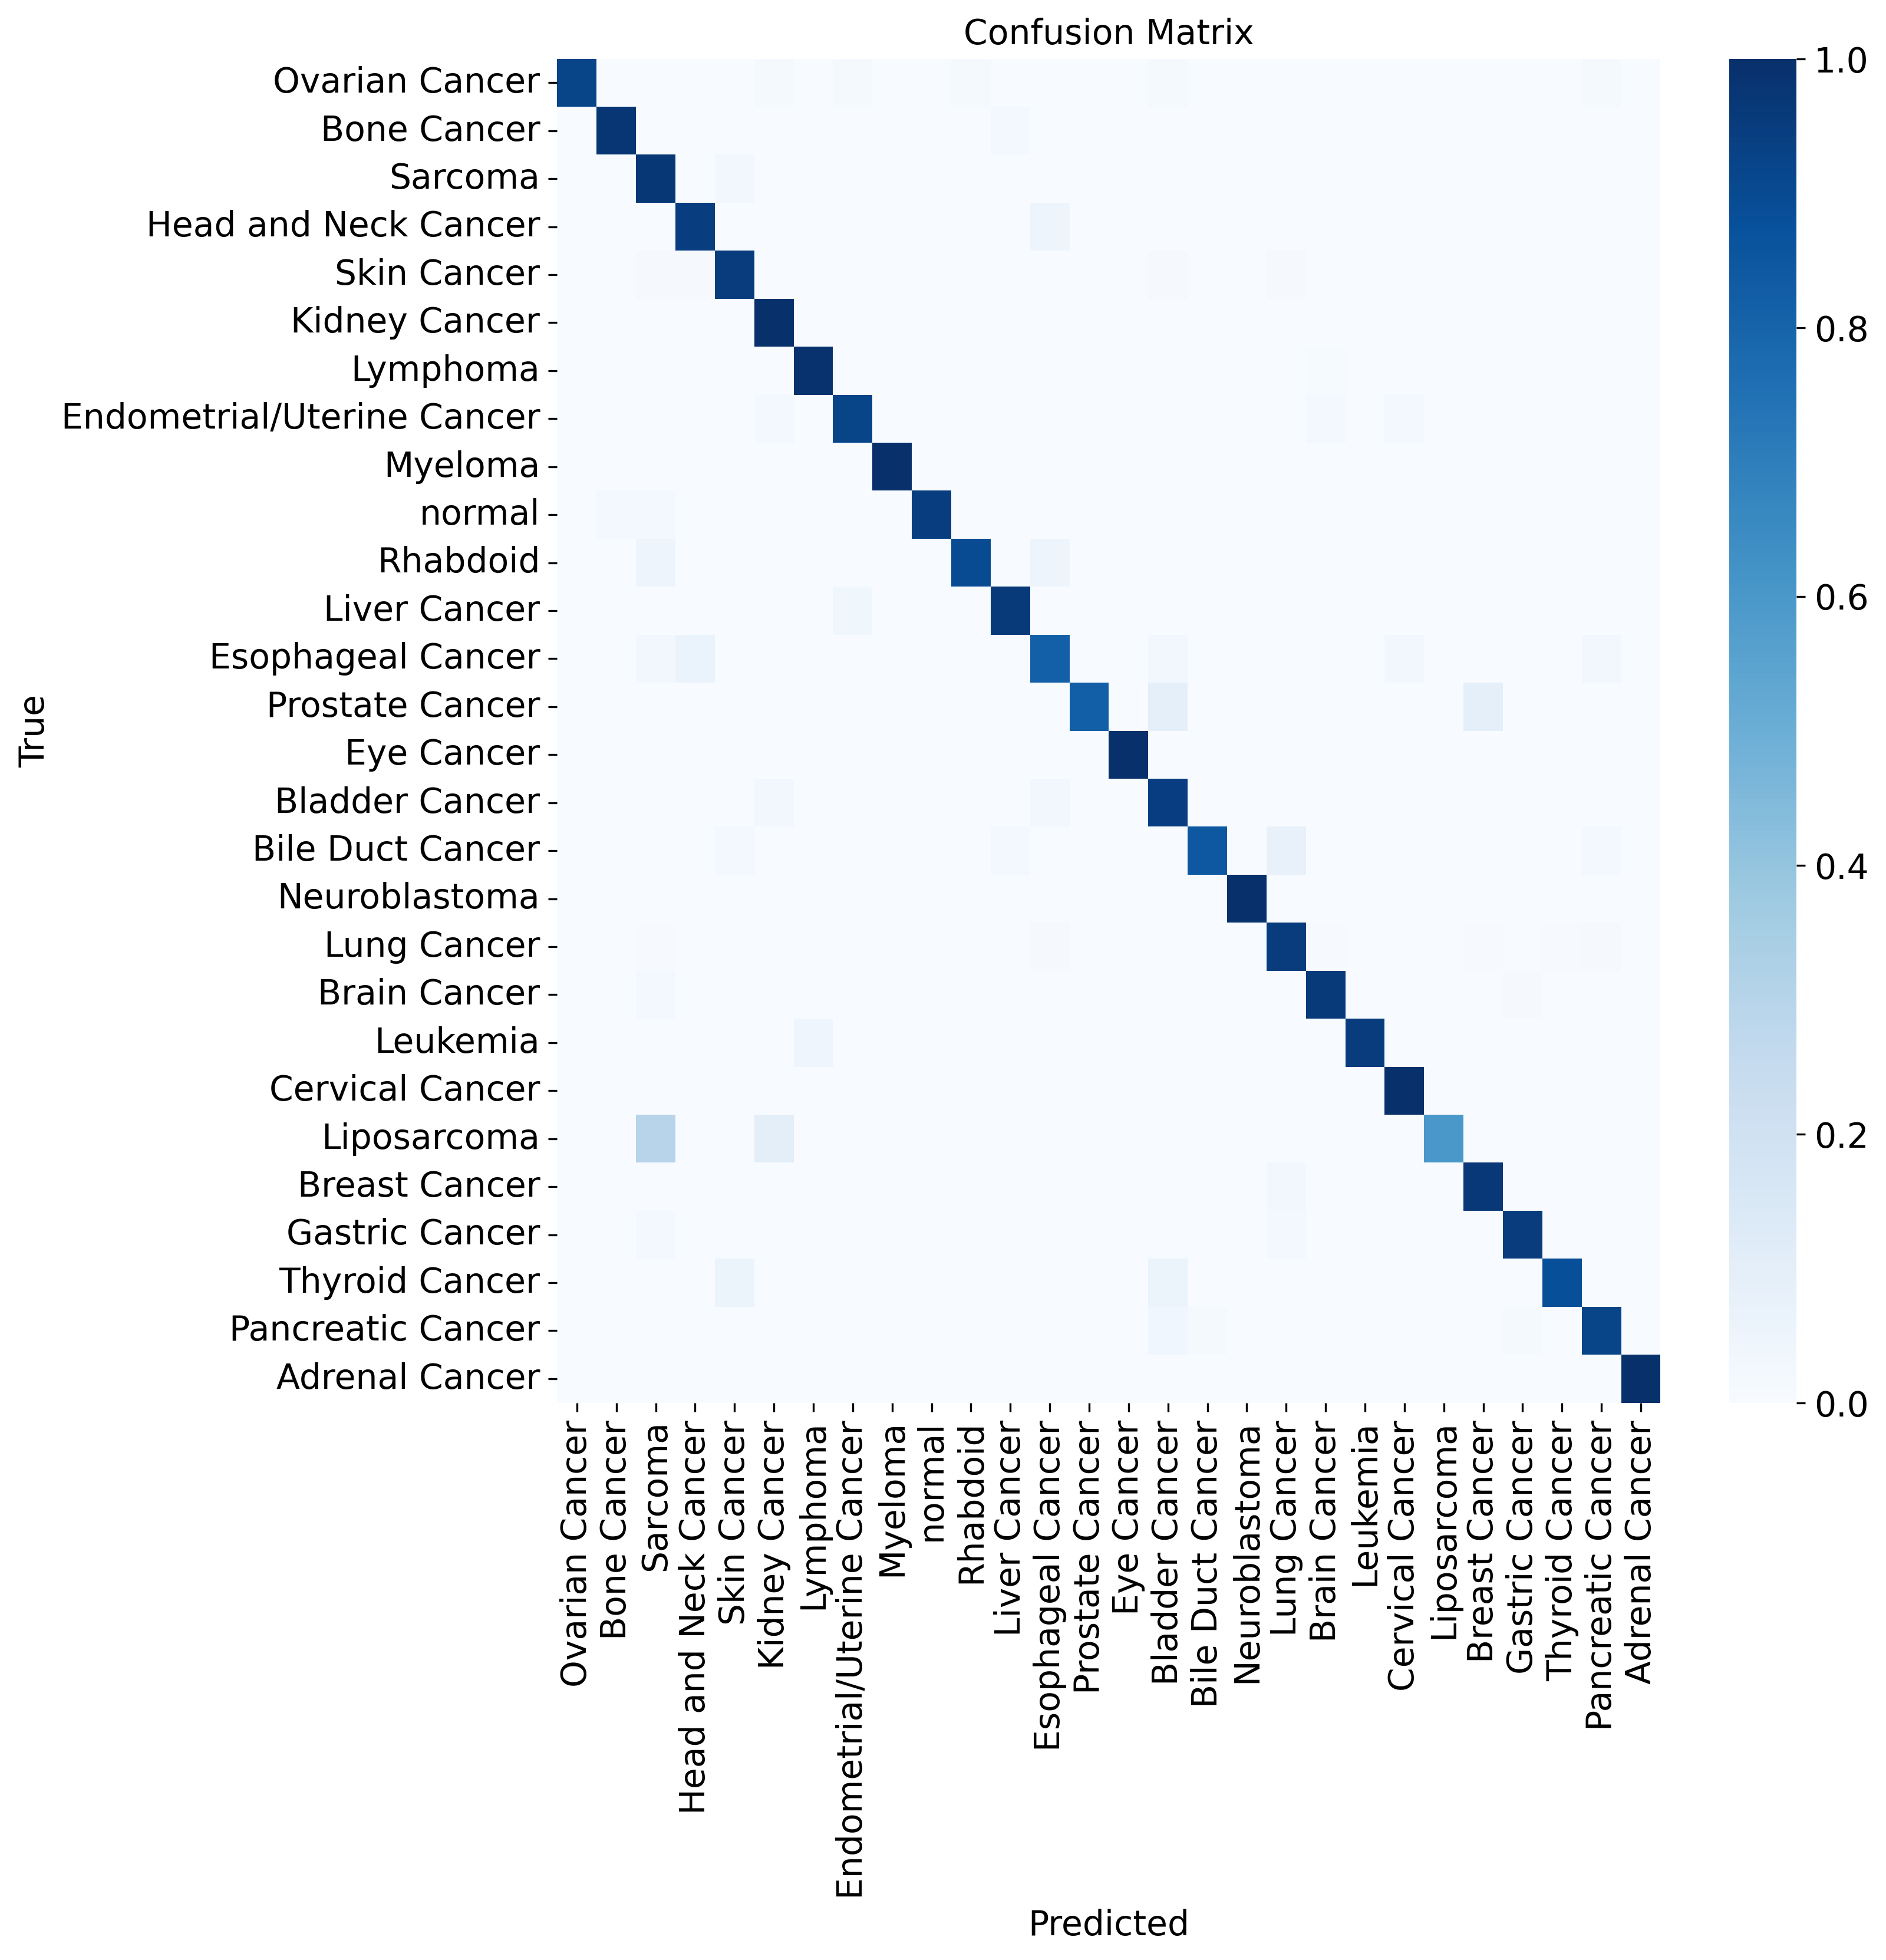

In [21]:
conf = evaluator.get_confusion_matrix(only='historical_cl', of="disease_type")

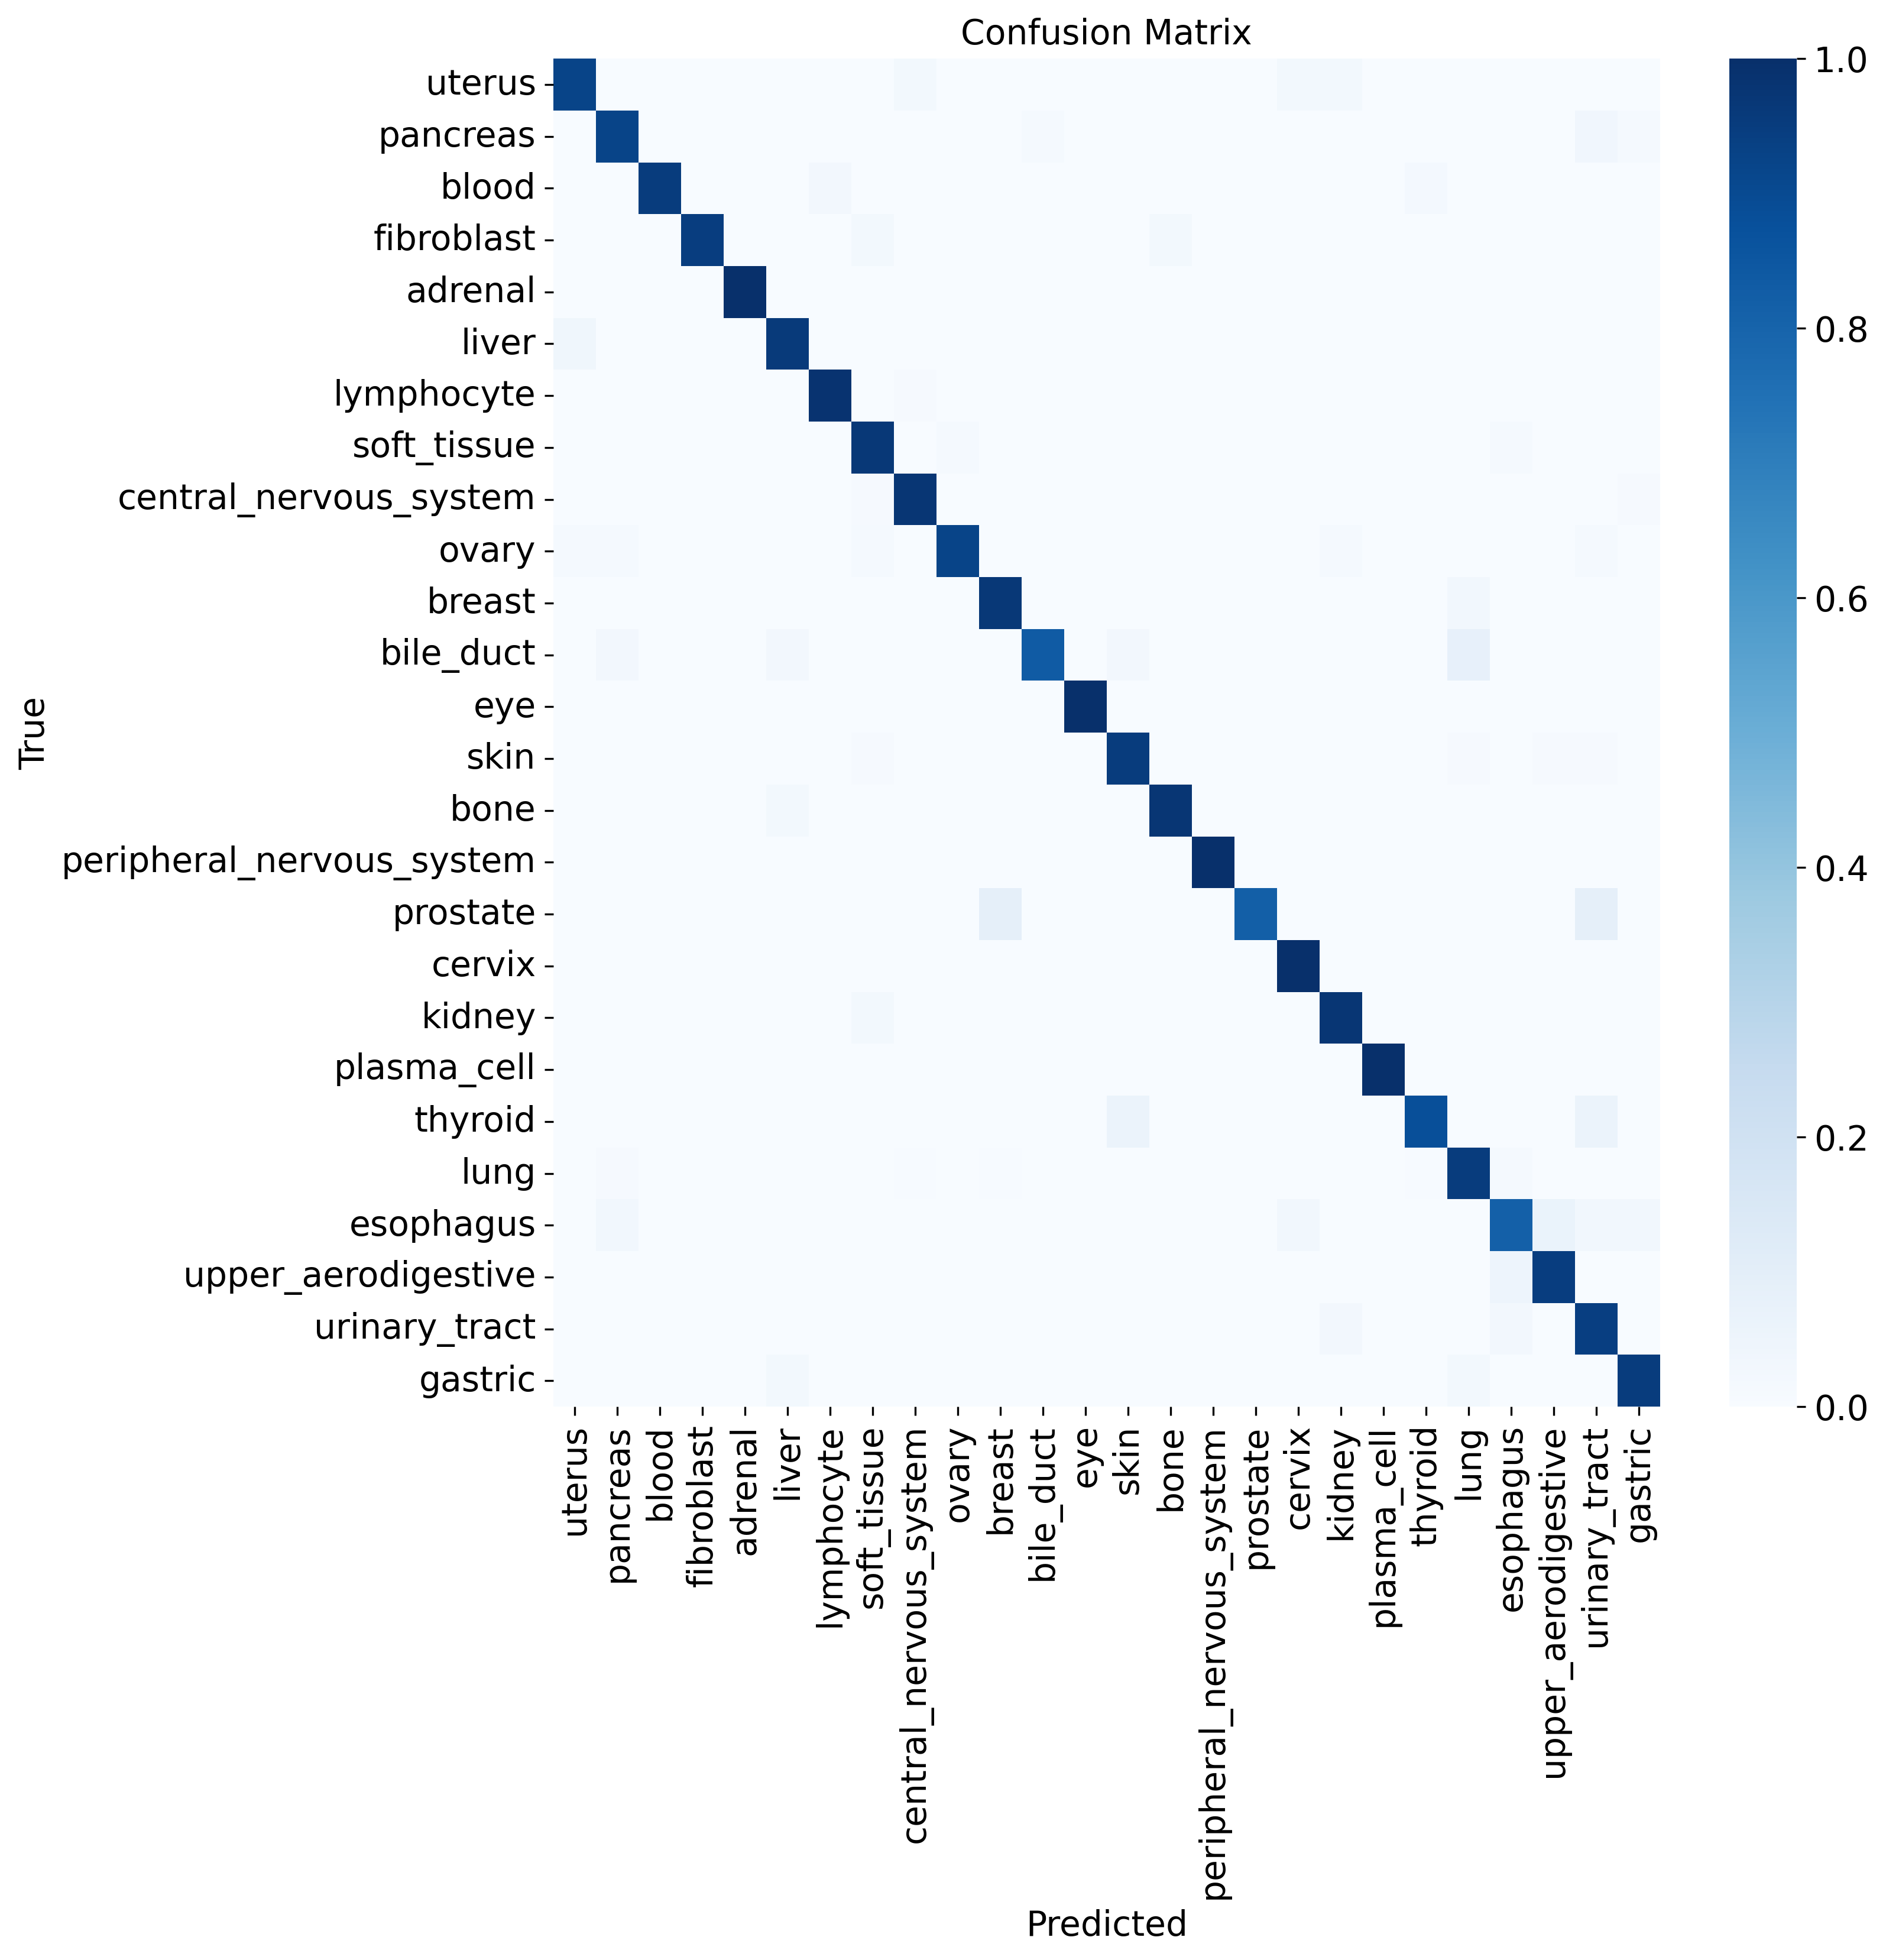

In [22]:
conf = evaluator.get_confusion_matrix(only="historical_cl", of="tissue_type")

In [24]:
from captum.attr import LRP
import torch.nn as nn
import seaborn as sns
import gseapy
from genepy import rna

In [28]:
lrpc = LRP(Newnn(evaluator.model.model.encoder, evaluator.model.model.classifier))

In [249]:
_, res = evaluator.explain_predictions(on = "blood", of = "historical_cl", using="Saliency", do_gsea=False)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


fetching gene names from biomart cache
1 count not be parsed... we don't have all genes already


In [252]:
res[0]=res[0].abs()*60

In [237]:
# case
on = "lung"
of = "historical_cl"
inp = torch.tensor(evaluator.model.adata[(evaluator.model.adata.obs.tissue_type == on) & (evaluator.model.adata.obs.cell_type == of)].X) 
attr = lrpc.attribute(inputs = inp, additional_forward_args = torch.tensor([[0,1]] * inp.shape[0]), target = evaluator.model.model.predictor_encoder[on])
res = pd.DataFrame(data = attr.detach().numpy(), columns = dataset.var.index, index = dataset[(dataset.obs.tissue_type == on) & (dataset.obs.cell_type == of)].obs.index).mean()

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [209]:
res = pd.DataFrame(dataset[(dataset.obs.tissue_type==on) & (dataset.obs.cell_type==of)].X.mean(0), index = dataset.var.index)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

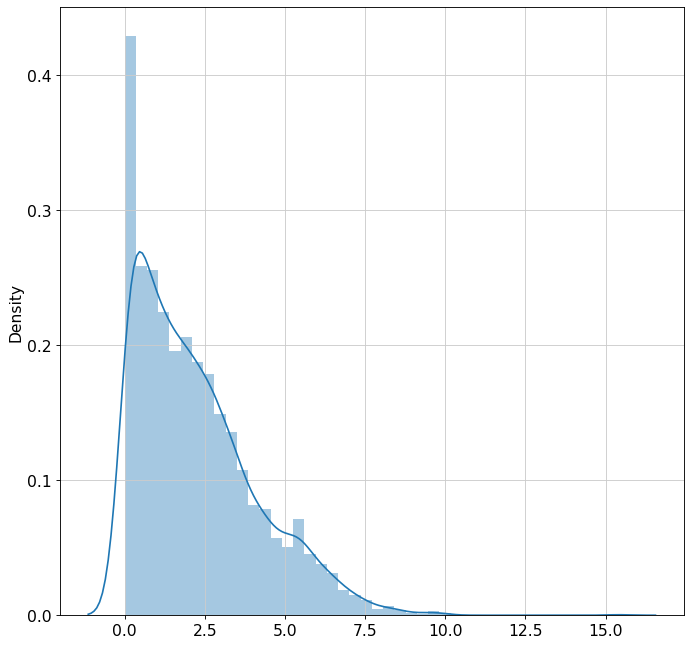

In [210]:
sns.distplot(res)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='0', ylabel='Density'>

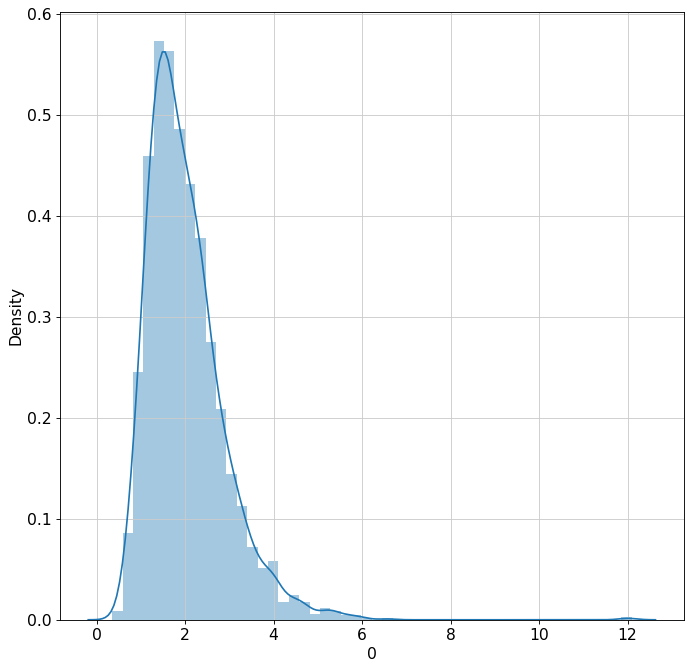

In [258]:
sns.distplot(res[0])

In [250]:
res=res.abs()*60

TypeError: bad operand type for abs(): 'str'

In [276]:
val = evaluator.explain_predictions(on='liver',
                            of='historical_cl',
                            using="LRP",
                            do_gsea=True, 
                            sets=['temp/genesets/c8.all.v7.5.1.entrez.gmt'],
                            processes=6,
                            permutation_num=100, # reduce number to speed up testing
                            outdir='test/prerank_report_c8', 
                            format='png', 
                            seed=6)[0]

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fetching gene names from biomart cache
1 count not be parsed... we don't have all genes already


In [280]:
val.sort_values(by="es", ascending=False).iloc[:30]

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
7,MENON_FETAL_KIDNEY_1_EMBRYONIC_RED_BLOOD_CELLS,0.854314,1.627839,0.000000,0.003752,126,16,6192;23705;3399;2353;116372;4288;9232;10581;11...,6192;23705;3399;2353;116372;4288
8,TRAVAGLINI_LUNG_NATURAL_KILLER_T_CELL,0.807260,1.583471,0.000000,0.005558,34,15,7503;3398;3107;3887;2625;7852;924;5996;84525;9...,7503;3398
9,ZHENG_CORD_BLOOD_C7_PUTATIVE_LYMPHOID_PRIMED_M...,0.792185,1.541358,0.000000,0.010005,95,20,7503;4509;378938;3428;53335;10410;56654;5791;1...,7503;4509;378938
10,TRAVAGLINI_LUNG_FIBROMYOCYTE_CELL,0.769449,1.485914,0.000000,0.030014,25,15,7503;1191;9076;72;1152;158471;51435;3778;64265...,7503;1191;9076
35,ZHONG_PFC_C2_SOX5_BCL11B_POS_EXCITATORY_NEURON,0.720919,1.385744,0.040404,0.121555,28,16,6192;9086;3303;4008;11343;857;5274;7447;5648;3...,6192;9086;3303;4008
11,MENON_FETAL_KIDNEY_5_PROXIMAL_TUBULE_CELLS,0.718154,1.454466,0.000000,0.067531,112,39,6192;3398;1191;348;3397;307;23767;6696;23475;2...,6192;3398;1191;348;3397;307;23767;6696;23475;2...
28,MENON_FETAL_KIDNEY_0_CAP_MESENCHYME_CELLS,0.708021,1.355237,0.000000,0.116113,90,22,7503;4212;116372;5763;4288;23089;7025;55740;70...,7503;4212;116372;5763;4288;23089;7025;55740;70...
16,BUSSLINGER_DUODENAL_TRANSIT_AMPLIFYING_CELLS,0.701311,1.404592,0.000000,0.102399,194,30,3880;2950;4257;216;3875;4072;4502;4288;3159;38...,3880;2950;4257;216;3875;4072;4502;4288;3159;38...
14,MENON_FETAL_KIDNEY_6_COLLECTING_DUCT_CELLS,0.695988,1.421771,0.000000,0.092185,94,49,1191;3880;2950;6277;216;3315;2353;3875;6926;40...,1191;3880;2950;6277;216;3315;2353;3875;6926;40...
26,BUSSLINGER_GASTRIC_PPP1R1B_POSITIVE_CELLS,0.694936,1.379123,0.000000,0.114835,121,36,1191;2950;3613;2353;2877;4072;4069;6662;79083;...,1191;2950;3613;2353;2877;4072;4069;6662;79083;...


In [281]:
a

NameError: name 'a' is not defined

In [277]:
evaluator.explain_predictions(on='kidney',
                            of='tumor',
                            using="LRP",
                            do_gsea=True, 
                            sets=['temp/genesets/c8.all.v7.5.1.entrez.gmt'],
                            processes=6,
                            permutation_num=100, # reduce number to speed up testing
                            outdir='test/prerank_report_c8', 
                            format='png', 
                            seed=6)[0].sort_values(by="es", ascending=False).iloc[:30]

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fetching gene names from biomart cache
1 count not be parsed... we don't have all genes already


,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
0,DESCARTES_FETAL_EYE_ASTROCYTES,0.852643,1.824301,0.000000,0.000000,37,17,486;7849;5076;3371;4982;10840;3773;2326;55885;...,486;7849;5076;3371;4982
1,ZHONG_PFC_C2_SOX5_BCL11B_POS_EXCITATORY_NEURON,0.824360,1.709132,0.000000,0.049870,28,16,6192;9086;384;857;387914;4008;1428;11343;5648;...,6192;9086
11,ZHENG_CORD_BLOOD_C7_PUTATIVE_LYMPHOID_PRIMED_M...,0.762407,1.614272,0.000000,0.143625,95,20,7503;284422;4509;378938;2995;10410;8519;11010;...,7503;284422;4509;378938
7,DESCARTES_MAIN_FETAL_LENS_FIBRE_CELLS,0.762110,1.590900,0.000000,0.132511,280,15,1410;378938;55214;3299;635;6652;56243;2171;794...,1410;378938;55214;3299;635;6652;56243
3,MENON_FETAL_KIDNEY_0_CAP_MESENCHYME_CELLS,0.747971,1.664726,0.000000,0.084778,90,22,7503;684;5076;23089;7026;4192;23157;5947;7846;...,7503;684;5076;23089;7026;4192
5,TRAVAGLINI_LUNG_NATURAL_KILLER_T_CELL,0.742340,1.588403,0.000000,0.118440,34,15,7503;3398;7852;84525;3002;969;4818;5996;1521;9...,7503;3398;7852;84525
2,MENON_FETAL_KIDNEY_5_PROXIMAL_TUBULE_CELLS,0.740489,1.694290,0.000000,0.053194,112,39,6192;284422;5174;10653;3398;1004;4036;23475;87...,6192;284422;5174;10653;3398;1004;4036;23475;87...
8,TRAVAGLINI_LUNG_FIBROMYOCYTE_CELL,0.738631,1.603174,0.010309,0.136310,25,15,7503;1152;358;9076;91522;158471;3778;1191;1026...,7503;1152;358;9076;91522;158471;3778
16,MENON_FETAL_KIDNEY_1_EMBRYONIC_RED_BLOOD_CELLS,0.710781,1.432289,0.070000,0.241641,126,16,6192;3399;23705;3043;3039;65108;2353;10581;923...,6192;3399
12,LAKE_ADULT_KIDNEY_C21_COLLECTING_DUCT_INTERCAL...,0.704351,1.540860,0.000000,0.152329,103,20,7503;771;51454;8631;3655;90102;256764;10512;85...,7503;771;51454;8631;3655;90102


In [275]:
evaluator.explain_predictions(on='kidney',
                            of='historical_cl',
                            using="LRP",
                            do_gsea=True, 
                            sets=['temp/genesets/c8.all.v7.5.1.entrez.gmt'],
                            processes=6,
                            permutation_num=100, # reduce number to speed up testing
                            outdir='test/prerank_report_c8', 
                            format='png', 
                            seed=6)[0].sort_values(by="es", ascending=False).iloc[:30]

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fetching gene names from biomart cache
1 count not be parsed... we don't have all genes already


,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
3,DESCARTES_FETAL_EYE_ASTROCYTES,0.792497,1.459667,0.000000,0.066572,37,17,486;7849;5076;3371;4982;3773;9201;1471;10840;2...,486;7849;5076;3371;4982
1,DESCARTES_FETAL_PLACENTA_TROPHOBLAST_GIANT_CELLS,0.771970,1.486423,0.000000,0.039943,92,15,9518;3624;22836;26353;113452;6382;7980;7869;84...,9518;3624;22836;26353;113452;6382
5,ZHONG_PFC_C2_SOX5_BCL11B_POS_EXCITATORY_NEURON,0.771220,1.411117,0.010000,0.161771,28,16,6192;9086;387914;11343;384;857;3303;1428;3488;...,6192;9086;387914
2,TRAVAGLINI_LUNG_NATURAL_KILLER_T_CELL,0.766480,1.451913,0.000000,0.064908,34,15,7503;3398;3887;3107;7852;84525;969;1521;5996;2...,7503;3398;3887
60,DESCARTES_MAIN_FETAL_LENS_FIBRE_CELLS,0.752189,1.334798,0.020000,0.390557,280,15,1410;55214;378938;3299;6652;56243;143458;635;7...,1410;55214;378938;3299;6652;56243
17,DESCARTES_FETAL_HEART_ENDOCARDIAL_CELLS,0.750542,1.298735,0.050000,0.345300,38,16,771;3624;6299;104355288;84952;1009;83872;10205...,771;3624
12,MENON_FETAL_KIDNEY_1_EMBRYONIC_RED_BLOOD_CELLS,0.750497,1.357778,0.000000,0.328106,126,16,6192;3399;23705;4288;10581;9232;116372;7153;30...,6192;3399;23705;4288
4,MENON_FETAL_KIDNEY_5_PROXIMAL_TUBULE_CELLS,0.743276,1.410037,0.000000,0.138137,112,39,6192;2791;23475;5174;3398;6281;1535;307;132299...,6192;2791;23475;5174;3398;6281;1535;307;132299...
14,GAUTAM_EYE_IRIS_CILIARY_BODY_ACTIVATED_T_CELLS,0.736508,1.350860,0.040000,0.332029,127,17,970;54843;132299;26999;10417;84433;147968;1004...,970;54843;132299;26999
29,BUSSLINGER_GASTRIC_CHIEF_CELLS,0.724528,1.326843,0.020000,0.356767,56,25,4501;2752;7026;4494;333;3485;4502;80760;1028;7...,4501;2752;7026;4494;333;3485;4502;80760;1028


In [274]:
evaluator.explain_predictions(on='blood',
                            of='historical_cl',
                            using="LRP",
                            do_gsea=True, 
                            sets=['temp/genesets/c8.all.v7.5.1.entrez.gmt'],
                            processes=6,
                            permutation_num=100, # reduce number to speed up testing
                            outdir='test/prerank_report_c8', 
                            format='png', 
                            seed=6)[0].sort_values(by="es", ascending=False).iloc[:30]

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fetching gene names from biomart cache
1 count not be parsed... we don't have all genes already


,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
4,DESCARTES_MAIN_FETAL_LENS_FIBRE_CELLS,0.794000,1.419773,0.020202,0.078224,280,15,378938;3299;4897;55214;1410;4199;79054;2171;10...,378938;3299
38,ZHONG_PFC_C2_SOX5_BCL11B_POS_EXCITATORY_NEURON,0.791934,1.399478,0.000000,0.115553,28,16,6192;9086;384;5274;4008;3303;55885;1428;3488;2...,6192;9086;384;5274;4008
3,MENON_FETAL_KIDNEY_10_IMMUNE_CELLS,0.786527,1.432077,0.000000,0.063911,83,30,199;397;11151;7940;7805;283131;1535;3936;3107;...,199;397;11151;7940;7805;283131;1535;3936;3107;...
25,GAUTAM_EYE_CHOROID_SCLERA_MONOCYTES,0.766155,1.394148,0.000000,0.097641,139,23,4509;3159;57580;1396;1808;1794;101;6624;3678;7...,4509;3159;57580;1396;1808;1794;101;6624;3678;7...
7,BUSSLINGER_GASTRIC_CHIEF_CELLS,0.761421,1.436292,0.000000,0.079888,56,25,2752;4501;4494;7494;1471;7026;3485;4502;1028;3...,2752;4501;4494;7494
5,DURANTE_ADULT_OLFACTORY_NEUROEPITHELIUM_B_CELLS,0.755930,1.373411,0.000000,0.078713,35,25,29802;11151;7805;3117;972;973;931;3109;974;330...,29802;11151;7805;3117;972;973;931;3109;974;330...
14,ZHENG_CORD_BLOOD_C7_PUTATIVE_LYMPHOID_PRIMED_M...,0.753564,1.350475,0.000000,0.091539,95,20,4509;378938;2995;6693;7503;284422;51237;10410;...,4509;378938;2995;6693;7503;284422;51237;10410;...
8,ZHENG_CORD_BLOOD_C2_PUTATIVE_BASOPHIL_EOSINOPH...,0.742099,1.373942,0.010000,0.081761,96,30,2752;378938;123;28951;7805;7431;10581;4000;395...,2752;378938;123;28951;7805;7431;10581;4000;395...
11,RUBENSTEIN_SKELETAL_MUSCLE_T_CELLS,0.736139,1.378405,0.000000,0.085595,181,38,6192;3561;397;11151;7805;1396;51316;1535;5790;...,6192;3561;397;11151;7805;1396;51316;1535;5790;...
34,RUBENSTEIN_SKELETAL_MUSCLE_B_CELLS,0.734814,1.382569,0.000000,0.102584,177,50,6192;29802;10235;7805;3117;51316;1535;5790;653...,6192;29802;10235;7805;3117;51316;1535;5790;653...


In [265]:
evaluator.explain_predictions(on='lung',
                            of='historical_cl',
                            using="LRP",
                            do_gsea=True, 
                            sets=['temp/genesets/c8.all.v7.5.1.entrez.gmt'],
                            processes=6,
                            permutation_num=100, # reduce number to speed up testing
                            outdir='test/prerank_report_c8', 
                            format='png', 
                            seed=6)[0].sort_values(by="es", ascending=False).iloc[:30]

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fetching gene names from biomart cache
1 count not be parsed... we don't have all genes already


,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
4,TRAVAGLINI_LUNG_FIBROMYOCYTE_CELL,0.717303,1.454312,0.010101,0.064461,25,15,7503;1152;1191;9076;51435;3778;10267;140597;72...,7503;1152;1191;9076;51435;3778
8,ZHONG_PFC_C2_SOX5_BCL11B_POS_EXCITATORY_NEURON,0.716896,1.464889,0.010101,0.077399,28,16,6192;3303;4008;857;11343;384;3488;55885;9086;4...,6192;3303;4008;857;11343;384;3488
6,BUSSLINGER_ESOPHAGEAL_EARLY_SUPRABASAL_CELLS,0.715834,1.439424,0.000000,0.076567,79,18,4502;3303;2353;9232;3613;9055;3866;7153;6241;9...,4502;3303;2353;9232;3613;9055;3866;7153;6241;9...
9,BUSSLINGER_DUODENAL_BCHE_CELLS,0.710617,1.473460,0.000000,0.086554,43,24,4502;3958;8644;4501;2934;54502;51316;2950;1001...,4502;3958;8644;4501;2934;54502;51316;2950
5,ZHENG_CORD_BLOOD_C7_PUTATIVE_LYMPHOID_PRIMED_M...,0.694880,1.456873,0.010000,0.070908,95,20,7503;4509;378938;8519;10410;56654;11010;5791;2...,7503;4509;378938;8519;10410;56654
19,FAN_OVARY_CL0_XBP1_SELK_HIGH_STROMAL_CELL,0.686948,1.383225,0.000000,0.118893,143,18,23089;481;6383;54206;2274;1266;3488;283131;264...,23089;481;6383;54206;2274;1266;3488
39,AIZARANI_LIVER_C12_NK_NKT_CELLS_4,0.682033,1.363380,0.000000,0.156160,49,21,3303;7832;3936;8519;5880;55466;3304;7456;864;3...,3303;7832;3936;8519;5880;55466
11,MENON_FETAL_KIDNEY_6_COLLECTING_DUCT_CELLS,0.681459,1.477175,0.000000,0.095875,94,49,3856;1958;3880;2353;1191;231;3315;10123;3875;7...,3856;1958;3880;2353;1191;231;3315;10123;3875;7...
17,ZHENG_CORD_BLOOD_C2_PUTATIVE_BASOPHIL_EOSINOPH...,0.679199,1.403441,0.000000,0.117180,96,30,301;123;378938;2752;2624;7431;3732;25825;80223...,301;123;378938;2752;2624;7431;3732;25825;80223...
21,HAY_BONE_MARROW_CD34_POS_MKP,0.671941,1.341438,0.050000,0.144055,63,21,306;56952;2624;22943;11343;653689;5881;7168;36...,306;56952;2624;22943;11343;653689


In [260]:
pre_res.res2d[pre_res.res2d.pval<0.05].sort_values(by="es", ascending=False).iloc[:30]

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
DESCARTES_MAIN_FETAL_BRONCHIOLAR_AND_ALVEOLAR_EPITHELIAL_CELLS,0.585809,2.236630,0.000000,0.001827,50,16,6439;27075;7080;9244;153572;79192;653509;6440;...,6439;27075;7080;9244;153572;79192;653509;6440
ZHONG_PFC_C2_SOX5_BCL11B_POS_EXCITATORY_NEURON,0.550322,2.240918,0.000000,0.001300,28,16,6192;26047;9086;7447;3488;3303;4045;5274;1428;...,6192;26047;9086;7447;3488
TRAVAGLINI_LUNG_FIBROMYOCYTE_CELL,0.518919,1.991296,0.011494,0.037903,25,15,7503;91522;642658;10267;1191;72;84624;140597;1...,7503;91522;642658;10267;1191
ZHENG_CORD_BLOOD_C7_PUTATIVE_LYMPHOID_PRIMED_MULTIPOTENT_PROGENITOR_1,0.518372,2.071257,0.000000,0.017199,95,20,7503;114900;378938;4509;284422;2322;6693;6402;...,7503;114900;378938;4509;284422;2322;6693;6402
DURANTE_ADULT_OLFACTORY_NEUROEPITHELIUM_GLOBOSE_BASAL_CELLS,0.516884,1.917168,0.000000,0.059871,35,16,2018;55502;794;7345;6252;11075;9355;1152;92312...,2018;55502;794;7345;6252;11075;9355
MENON_FETAL_KIDNEY_2_NEPHRON_PROGENITOR_CELLS,0.478213,1.890927,0.011111,0.070767,44,19,2018;3213;2122;3206;3912;3217;28951;3234;5455;...,2018;3213;2122;3206;3912;3217;28951;3234
DESCARTES_FETAL_PLACENTA_TROPHOBLAST_GIANT_CELLS,0.476457,1.925428,0.036145,0.058965,92,15,7980;7869;3624;8000;113452;119587;827;26353;95...,7980;7869;3624;8000;113452;119587
DESCARTES_MAIN_FETAL_SMOOTH_MUSCLE_CELLS,0.467880,1.657845,0.020833,0.245013,45,16,4629;1464;55107;56901;4854;6876;72;7060;1293;1...,4629;1464;55107;56901;4854;6876;72;7060
DESCARTES_FETAL_HEART_SMOOTH_MUSCLE_CELLS,0.454344,1.801664,0.021978,0.128952,46,16,6004;4629;56901;4854;6876;183;72;7060;114757;2...,6004;4629;56901;4854;6876;183;72;7060
